In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_3dim5000.npz')                  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h', 'omega_b', 'omega_cdm']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples: ', len(train_params['omega_b'])) 

number of training samples:  5000


In [6]:
cosmo_params = np.zeros((len(train_params['omega_b']), 3))
print(cosmo_params[199])

cosmo_params[:, 0] = train_params['h']
cosmo_params[:, 1] = train_params['omega_b']
cosmo_params[:, 2] = train_params['omega_cdm']

[0. 0. 0.]


In [7]:
print(cosmo_params[0])
print(cosmo_params[4999])

[0.7015163  0.02092098 0.17426485]
[0.65366673 0.02242208 0.18358672]


In [8]:
len(train_params['h'])

5000

In [9]:
#%%time
## Training input params:
h = cosmo_params[:, 0]
# ombh2:
omega_b = cosmo_params[:, 1]
# omch2:
omega_c = cosmo_params[:, 2]

In [10]:
with open('pk_data_3dim5000.pkl', 'rb') as f:
    pk_matrix = pickle.load(f)

In [11]:
# Training input params and output param:

train_H0 = 100*h                               #1x400                     # np.arrays, sizes len(train_params['h'])
train_omega_b = omega_b                        #1x400
train_omega_c = omega_c                        #1x400
train_pk = pk_matrix                           #400x1400                   # don't need kh, stays the same

In [12]:
input_params = np.vstack([train_H0, train_omega_b, train_omega_c])        # n_samples = no. of rows

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0', 'Omega_b', 'Omega_cdm']

output_data = pd.DataFrame(train_pk)                                       
print( input_data)                                                         #1400x3
#print(output_data)

(5000, 3)
(5000, 500)
             H0   Omega_b  Omega_cdm
0     70.151630  0.020921   0.174265
1     64.307261  0.018337   0.166783
2     66.784557  0.018113   0.122374
3     75.560712  0.019995   0.203271
4     64.492899  0.021805   0.179906
...         ...       ...        ...
4995  79.942388  0.024654   0.068644
4996  75.595919  0.020550   0.137057
4997  75.947990  0.023314   0.092769
4998  69.361072  0.021008   0.052240
4999  65.366673  0.022422   0.183587

[5000 rows x 3 columns]


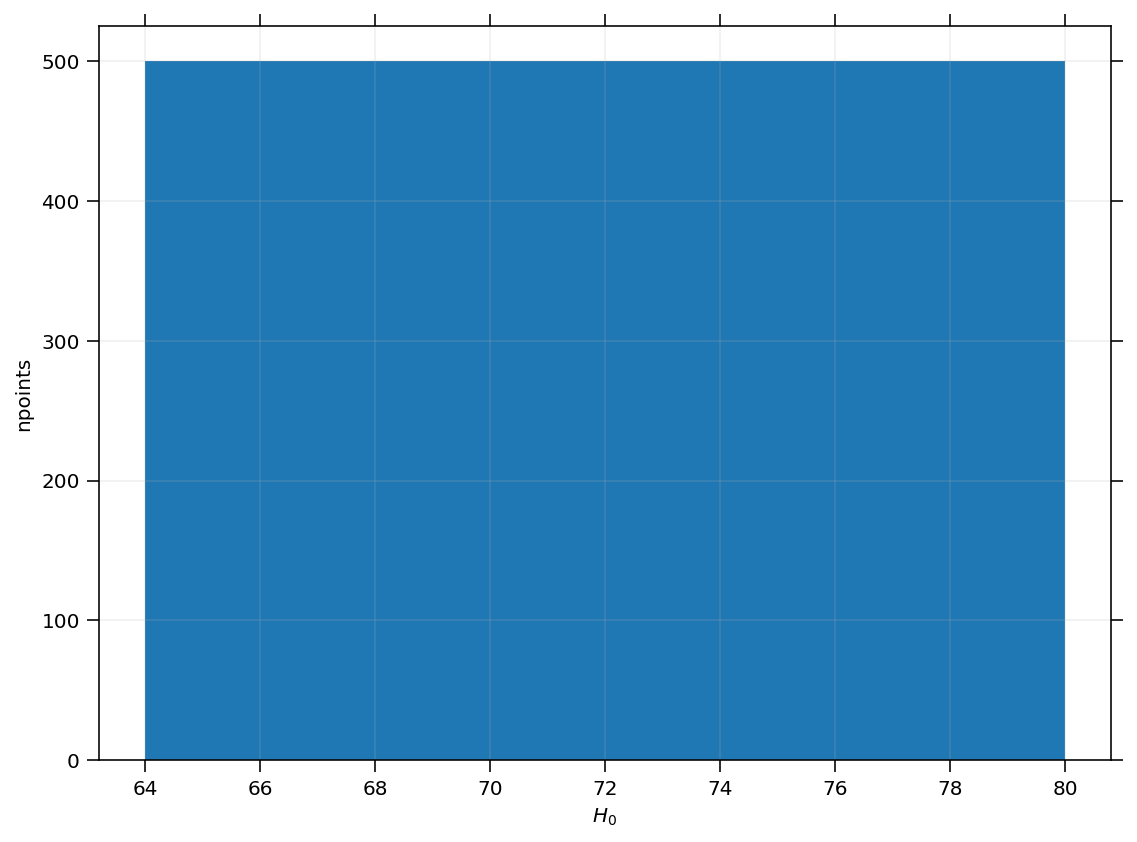

In [13]:
plt.figure(figsize = (8,6))
plt.hist(input_data['H0'])
#plt.hist(input_data['Omega_b'])
#plt.hist(input_data['Omega_cdm'])
plt.xlabel(r'$H_{0}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()

In [14]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

scaled_input = train_input_data.fit(input_data)
scaled_output = test_output_data.fit(output_data)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data)                         
y = scaled_output.transform(output_data)                    
print(X)

[[-0.40010374 -0.28648121  0.42019553]
 [-1.66519368 -1.56473473  0.29063813]
 [-1.12895074 -1.67558598 -0.47839244]
 ...
 [ 0.85459389  0.89754875 -0.99107949]
 [-0.57123037 -0.24352635 -1.69290649]
 [-1.43587015  0.45622219  0.58162267]]


-1.7317044320414525 5.832604448749877


(array([[500., 500., 500., 500., 500., 500., 500., 500., 500., 500.],
        [500., 500., 500., 500., 500., 500., 500., 500., 500., 500.],
        [500., 500., 500., 500., 500., 500., 500., 500., 500., 500.]]),
 array([-1.73170443e+00, -1.38536355e+00, -1.03902266e+00, -6.92681773e-01,
        -3.46340886e-01,  4.44089210e-16,  3.46340886e-01,  6.92681773e-01,
         1.03902266e+00,  1.38536355e+00,  1.73170443e+00]),
 <a list of 3 BarContainer objects>)

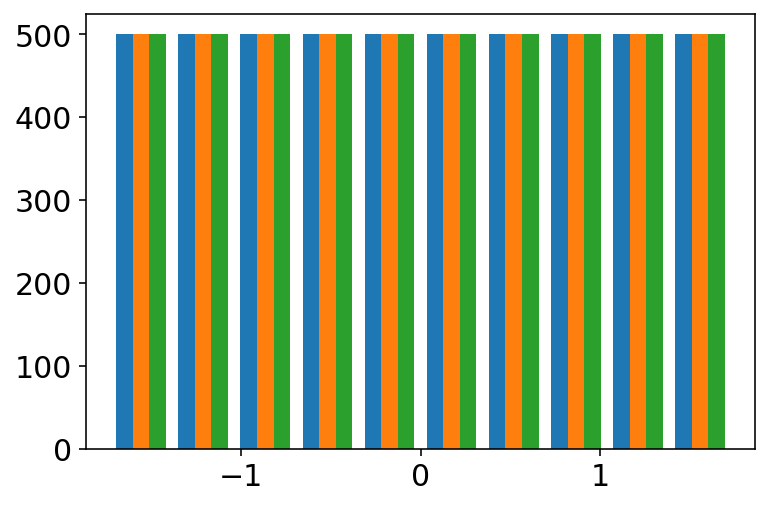

In [15]:
print(X.min(), y.max())
plt.hist(X)

In [16]:
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_train))    # 4000x3
print(X_train.shape[1])     # 3

(4000, 3)
3


In [17]:
print(X_train)

[[-0.28024583  0.1465315   1.19615431]
 [-1.52801525  0.38278324  1.4989168 ]
 [-0.98761539  0.43890168  1.07352511]
 ...
 [ 0.59755754 -0.41950271 -0.18671508]
 [-0.85390107 -1.62362446  1.15597073]
 [-0.80124672 -1.47605373 -0.92456874]]


In [18]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test ssamples, pts:",np.shape(X_test))
print("X_train:", X_train)
print("X_test:", X_test)

y_test samples, pts: (1000, 500)
y_train samples, pts: (4000, 500)
X_train samples, pts: (4000, 3)
X_test ssamples, pts: (1000, 3)
X_train: [[-0.28024583  0.1465315   1.19615431]
 [-1.52801525  0.38278324  1.4989168 ]
 [-0.98761539  0.43890168  1.07352511]
 ...
 [ 0.59755754 -0.41950271 -0.18671508]
 [-0.85390107 -1.62362446  1.15597073]
 [-0.80124672 -1.47605373 -0.92456874]]
X_test: [[-0.4361304  -0.10149818 -0.65783291]
 [-0.8518226   1.56265627  1.20723944]
 [-0.54906012  0.95228155  1.56750601]
 ...
 [ 0.62527035 -0.28024583  0.74304981]
 [-1.09084562  1.48713885  0.40148939]
 [-1.41300708  0.82549543  0.54906012]]


%%time
#Building the NN:

tf_model = Sequential()
# Defining the first layer of the model
tf_model.add(Dense(units=350, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=350, kernel_initializer='normal', activation='relu'))
 
# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=350, kernel_initializer='normal', activation='relu'))

# # Defining the 3rd hidden layer of the model
# tf_model.add(Dense(units=350, kernel_initializer='normal', activation='relu'))  

## Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=512, kernel_initializer='normal', activation='relu')) 

tf_model.add(Dense(400, kernel_initializer='normal'))
 
opt = keras.optimizers.Adam(learning_rate=0.008)
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt)
 
# Fitting the ANN to the Training set
tf_model.fit(X_train, y_train, batch_size = 50, epochs = 500, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#93.11908522914788 for 500 epochs, 350 units

In [51]:
%%time
#Building the NN:

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=350, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=350, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=350, kernel_initializer='normal', activation='relu'))

# Defining 3rd Hidden layer of the model
#tf_model.add(Dense(units=350, kernel_initializer='normal', activation='relu'))

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=350, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
opt = keras.optimizers.Adam(learning_rate=8e-5)
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt)
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 50, epochs = 500, validation_split=0.2, verbose=1)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#89.73150593184755, l_rate = 8e-5, 500 epochs, 350 units
tf_model.summary()

Epoch 1/500
64/64 [==============================] - 1s 9ms/step - loss: 0.9655 - val_loss: 0.8669
Epoch 2/500
64/64 [==============================] - 0s 7ms/step - loss: 0.5378 - val_loss: 0.2441
Epoch 3/500
64/64 [==============================] - 0s 8ms/step - loss: 0.1981 - val_loss: 0.1705
Epoch 4/500
64/64 [==============================] - 0s 7ms/step - loss: 0.1585 - val_loss: 0.1456
Epoch 5/500
64/64 [==============================] - 1s 9ms/step - loss: 0.1329 - val_loss: 0.1216
Epoch 6/500
64/64 [==============================] - 0s 6ms/step - loss: 0.1080 - val_loss: 0.0988
Epoch 7/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0872 - val_loss: 0.0826
Epoch 8/500
64/64 [==============================] - 1s 9ms/step - loss: 0.0740 - val_loss: 0.0704
Epoch 9/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0642 - val_loss: 0.0646
Epoch 10/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0572 - val_loss: 0.0566
Epoch 11/

64/64 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 84/500
64/64 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 85/500
64/64 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 86/500
64/64 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 87/500
64/64 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 88/500
64/64 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 89/500
64/64 [==============================] - 0s 5ms/step - loss: 9.6935e-04 - val_loss: 0.0012
Epoch 90/500
64/64 [==============================] - 0s 5ms/step - loss: 9.6673e-04 - val_loss: 0.0012
Epoch 91/500
64/64 [==============================] - 0s 5ms/step - loss: 9.2688e-04 - val_loss: 0.0014
Epoch 92/500
64/64 [==============================] - 0s 5ms/step - loss: 9.1894e-04 - val_loss: 0.00

64/64 [==============================] - 0s 5ms/step - loss: 3.6361e-04 - val_loss: 3.2693e-04
Epoch 160/500
64/64 [==============================] - 0s 6ms/step - loss: 2.3536e-04 - val_loss: 3.0302e-04
Epoch 161/500
64/64 [==============================] - 0s 6ms/step - loss: 3.0375e-04 - val_loss: 3.4479e-04
Epoch 162/500
64/64 [==============================] - 0s 7ms/step - loss: 3.0262e-04 - val_loss: 3.3667e-04
Epoch 163/500
64/64 [==============================] - 0s 7ms/step - loss: 2.7894e-04 - val_loss: 2.9644e-04
Epoch 164/500
64/64 [==============================] - 0s 6ms/step - loss: 2.4653e-04 - val_loss: 3.1524e-04
Epoch 165/500
64/64 [==============================] - 0s 5ms/step - loss: 2.3003e-04 - val_loss: 3.0627e-04
Epoch 166/500
64/64 [==============================] - 0s 5ms/step - loss: 2.2715e-04 - val_loss: 4.4224e-04
Epoch 167/500
64/64 [==============================] - 0s 5ms/step - loss: 2.2651e-04 - val_loss: 3.5530e-04
Epoch 168/500
64/64 [============

64/64 [==============================] - 0s 5ms/step - loss: 1.3607e-04 - val_loss: 1.6139e-04
Epoch 235/500
64/64 [==============================] - 0s 5ms/step - loss: 1.3200e-04 - val_loss: 2.0558e-04
Epoch 236/500
64/64 [==============================] - 0s 5ms/step - loss: 1.4992e-04 - val_loss: 2.3037e-04
Epoch 237/500
64/64 [==============================] - 0s 5ms/step - loss: 1.2664e-04 - val_loss: 1.3501e-04
Epoch 238/500
64/64 [==============================] - 0s 5ms/step - loss: 9.2202e-05 - val_loss: 1.4934e-04
Epoch 239/500
64/64 [==============================] - 0s 5ms/step - loss: 1.0221e-04 - val_loss: 1.5446e-04
Epoch 240/500
64/64 [==============================] - 0s 5ms/step - loss: 1.0066e-04 - val_loss: 1.3768e-04
Epoch 241/500
64/64 [==============================] - 0s 5ms/step - loss: 9.8870e-05 - val_loss: 1.4871e-04
Epoch 242/500
64/64 [==============================] - 0s 6ms/step - loss: 9.3988e-05 - val_loss: 1.3889e-04
Epoch 243/500
64/64 [============

64/64 [==============================] - 0s 7ms/step - loss: 8.7436e-05 - val_loss: 1.0074e-04
Epoch 310/500
64/64 [==============================] - 0s 6ms/step - loss: 7.8989e-05 - val_loss: 1.0059e-04
Epoch 311/500
64/64 [==============================] - 0s 6ms/step - loss: 8.9681e-05 - val_loss: 1.3982e-04
Epoch 312/500
64/64 [==============================] - 0s 6ms/step - loss: 8.1631e-05 - val_loss: 1.0723e-04
Epoch 313/500
64/64 [==============================] - 0s 6ms/step - loss: 5.9848e-05 - val_loss: 1.1274e-04
Epoch 314/500
64/64 [==============================] - 0s 6ms/step - loss: 6.8651e-05 - val_loss: 1.1482e-04
Epoch 315/500
64/64 [==============================] - 0s 6ms/step - loss: 9.6421e-05 - val_loss: 1.3070e-04
Epoch 316/500
64/64 [==============================] - 0s 6ms/step - loss: 7.7567e-05 - val_loss: 1.2663e-04
Epoch 317/500
64/64 [==============================] - 0s 6ms/step - loss: 2.1437e-04 - val_loss: 2.0046e-04
Epoch 318/500
64/64 [============

64/64 [==============================] - 0s 6ms/step - loss: 5.1838e-05 - val_loss: 6.6231e-05
Epoch 385/500
64/64 [==============================] - 0s 7ms/step - loss: 4.4636e-05 - val_loss: 8.6298e-05
Epoch 386/500
64/64 [==============================] - 0s 7ms/step - loss: 4.4874e-05 - val_loss: 8.0437e-05
Epoch 387/500
64/64 [==============================] - 0s 7ms/step - loss: 9.4491e-05 - val_loss: 9.6301e-04
Epoch 388/500
64/64 [==============================] - 0s 6ms/step - loss: 1.3810e-04 - val_loss: 8.7085e-05
Epoch 389/500
64/64 [==============================] - 0s 6ms/step - loss: 6.4144e-05 - val_loss: 1.0310e-04
Epoch 390/500
64/64 [==============================] - 0s 6ms/step - loss: 5.5770e-05 - val_loss: 9.7144e-05
Epoch 391/500
64/64 [==============================] - 0s 6ms/step - loss: 5.9688e-05 - val_loss: 6.3058e-05
Epoch 392/500
64/64 [==============================] - 0s 6ms/step - loss: 4.9149e-05 - val_loss: 8.2547e-05
Epoch 393/500
64/64 [============

64/64 [==============================] - 0s 6ms/step - loss: 5.1589e-05 - val_loss: 6.9187e-05
Epoch 460/500
64/64 [==============================] - 0s 6ms/step - loss: 3.5063e-05 - val_loss: 5.3634e-05
Epoch 461/500
64/64 [==============================] - 0s 6ms/step - loss: 3.4527e-05 - val_loss: 5.9121e-05
Epoch 462/500
64/64 [==============================] - 0s 6ms/step - loss: 3.4828e-05 - val_loss: 5.3703e-05
Epoch 463/500
64/64 [==============================] - 0s 6ms/step - loss: 4.1696e-05 - val_loss: 5.2617e-05
Epoch 464/500
64/64 [==============================] - 0s 6ms/step - loss: 3.3894e-05 - val_loss: 5.5492e-05
Epoch 465/500
64/64 [==============================] - 1s 8ms/step - loss: 3.5240e-05 - val_loss: 5.3569e-05
Epoch 466/500
64/64 [==============================] - 0s 7ms/step - loss: 3.3303e-05 - val_loss: 4.7006e-05
Epoch 467/500
64/64 [==============================] - 0s 6ms/step - loss: 5.5642e-05 - val_loss: 5.4717e-05
Epoch 468/500
64/64 [============

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

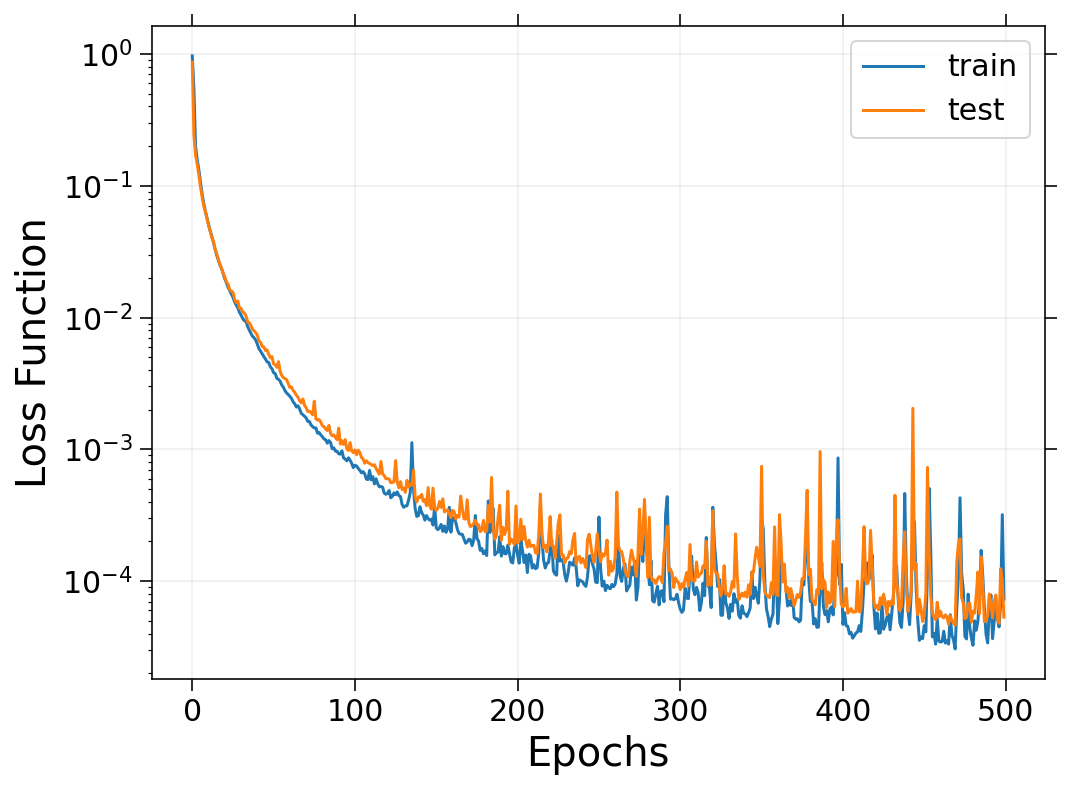

In [52]:
plt.figure(figsize = (8,6))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout

H0: 62.0 - 78.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250 80 0.019 0.09


parameters:  ['80', '0.019', '0.09']
user_list: [80.0, 0.019, 0.09]
cosmo_arr [[8.0e+01 1.9e-02 9.0e-02]]
cosmo_arr[0] [8.0e+01 1.9e-02 9.0e-02]
input_scaled [[ 1.73170443 -1.23693174 -1.03902266]]


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


H0: 80.0 Omega_b: 0.019 Omega_c: 0.09


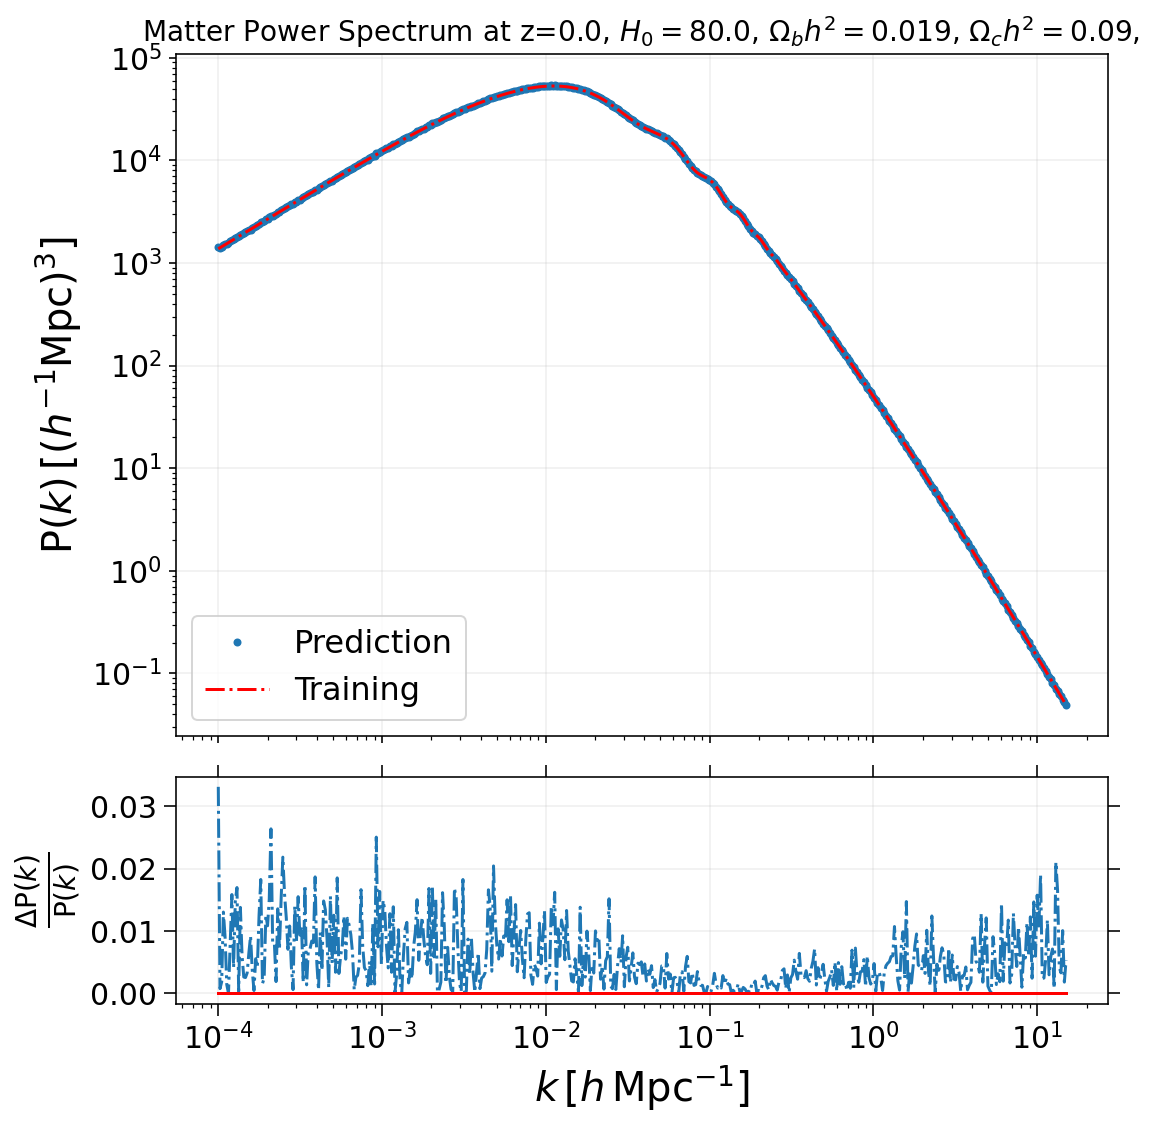

In [53]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: 62.0 - 78.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250 ')
    print("\n")
    user_list = input_cosmo_val.split()
    print('parameters: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data)
    input_scaled = scaled.transform(cosmo_arr)
    print('input_scaled', input_scaled)
    
    pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))

    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=cosmo_arr[0][1], omch2=cosmo_arr[0][2])
    pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=15.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur
    

    print('H0:' , cosmo_arr[0][0], 'Omega_b:', cosmo_arr[0][1], 'Omega_c:', cosmo_arr[0][2])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (8,8), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0.")                                                           # prediction              
    ax[0].loglog(camb_kh, camb_pk[0], 'r', linestyle='dashdot')                                        # CAMB            
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} = %0.5s$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = %0.6s$, ' %cosmo_arr[0][1] + '$\Omega_{c}h^{2} = %0.6s$, ' %cosmo_arr[0][2], fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction', 'Training'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].set_yscale('linear')
    #ax[1].set_ylim(0, 0.5)
    fig.tight_layout()
    #plt.savefig('power_spectrum_H0.pdf')
    plt.show()
    
    

Generate = calc_cosmo()
#67.5 0.024 0.15